<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span><ul class="toc-item"><li><span><a href="#Дерево-решений" data-toc-modified-id="Дерево-решений-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Дерево решений</a></span></li></ul></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span><ul class="toc-item"><li><span><a href="#случайный-лес" data-toc-modified-id="случайный-лес-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>случайный лес</a></span></li></ul></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

# Описание данных

`Признаки`

*RowNumber* — индекс строки в данных

*CustomerId* — уникальный идентификатор клиента

*Surname* — фамилия

*CreditScore* — кредитный рейтинг

*Geography* — страна проживания

*Gender* — пол

*Age* — возраст

*Tenure* — сколько лет человек является клиентом банка

*Balance* — баланс на счёте

*NumOfProducts* — количество продуктов банка, используемых клиентом

*HasCrCard* — наличие кредитной карты

*IsActiveMember* — активность клиента

*EstmatedSalary* — предполагаемая зарплата


`Целевой признак`

*Exited* — факт ухода клиента

## Подготовка данных

Сразу импортируем все библиотеки которые нам могут понадобиться.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, f1_score, roc_curve,precision_recall_curve
from sklearn.metrics import  mean_absolute_error, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import OrdinalEncoder,StandardScaler
from sklearn.utils import shuffle

вынесем константы в самый вверх ноутбука

In [2]:
RANDOM_STATE = 12345
TEST_SIZE = 0.25
CV = 2

In [3]:
df = pd.read_csv('/datasets/Churn.csv')

In [4]:
df.shape

(10000, 14)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [6]:
df.head(8)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1


In [7]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


**Вывод**

* Данных достаточно для анализа.
* Есть пропущенные значения.
* Есть нарушения стиля в названиях.

In [8]:
df.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [9]:
df = df.rename(columns={
    'RowNumber': 'row_number','CustomerId': 'customer_id','Surname': 'surname','CreditScore': 'credit_score', 'Geography': 'geography',
    'Gender': 'gender', 'Age': 'age', 'Tenure': 'tenure', 'Balance': 'balance', 'NumOfProducts': 'num_of_products',
    'HasCrCard': 'has_cr_card','IsActiveMember': 'is_active_member', 'EstimatedSalary': 'estimated_salary','Exited': 'exited'
})

пропуски просто будем удалять так как замена на, что либо будет мешать нашему обучению модели.

In [10]:
df.tenure.isna().sum()

909

In [11]:
df = df.dropna(subset=['tenure'])

In [12]:
df.isna().sum()

row_number          0
customer_id         0
surname             0
credit_score        0
geography           0
gender              0
age                 0
tenure              0
balance             0
num_of_products     0
has_cr_card         0
is_active_member    0
estimated_salary    0
exited              0
dtype: int64

а так же удалил ненужные для обучения столбцы типа: `row_number,customer_id,surname`

In [13]:
df = df.drop(['row_number','customer_id','surname'],axis=1)

## Исследование задачи

выполним кодирование техникой OHE так как она подходит под нашу задачу и без неё не получиться обучать модель.

**Были преобразованы такие признаки как:**

* geography -----> geography_Germany и geography_Spain
* gender -----> gender_Male 

In [14]:
df_ohe = pd.get_dummies(df, drop_first=True)
target = df_ohe['exited']
features = df_ohe.drop('exited', axis=1)

разделим наши выборки

In [15]:
features_train_valid, features_test, target_train_valid, target_test= train_test_split(features,target, test_size=0.4, random_state= RANDOM_STATE)

features_train, features_valid, target_train, target_valid = train_test_split(features_train_valid,target_train_valid, test_size=0.5, random_state= RANDOM_STATE)

далее масштабируем наши признаки методом скалер.

In [16]:
pd.options.mode.chained_assignment = None
numeric = [ 'tenure','credit_score', 'balance', 'age','estimated_salary']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric]= scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])

accuracy получилось не высоким,но хорошим.

In [17]:
model = DecisionTreeClassifier(random_state=RANDOM_STATE) # обучите модель с заданной глубиной дерева
model.fit(features_train,target_train) # обучите модель
# обучите модель
predicted_valid = model.predict(features_valid) # получите предсказания модели
accuracy_valid = accuracy_score(target_valid,predicted_valid) # посчитайте качество модели
print('accuracy нашей модели:',accuracy_valid)

accuracy нашей модели: 0.7744774477447744


## Борьба с дисбалансом

### Дерево решений

константная модель показывает уже лучше результат

In [18]:
target_pred_constant = pd.Series(0, index=target.index)
print(accuracy_score(target, target_pred_constant))

0.7960620393796062


нашли нашу проблему с дисбалансом. Наша модель видит в основном True Negative

In [19]:
print('матрица ошибок нашей модели')
confusion_matrix(target_valid,predicted_valid)

матрица ошибок нашей модели


array([[1855,  291],
       [ 324,  257]])

Полнота выявляет, какую долю положительных среди всех ответов выделила модель. Показатель я считаю не плохой!

In [20]:
print('Доля положительных ответов нашей модели:',recall_score(target_valid,predicted_valid))

Доля положительных ответов нашей модели: 0.4423407917383821


Точность тоже

In [21]:
print('Количество отрицательных ответов нашей модели:',precision_score(target_valid,predicted_valid))

Количество отрицательных ответов нашей модели: 0.46897810218978103


до поставленной задачи нам ещё долеко

In [22]:
print('f1 мера:',f1_score(target_valid,predicted_valid))

f1 мера: 0.4552701505757307


f1 на логистической получилось нормальным После увелечение выборки.

In [23]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train,4)

# < напишите код здесь >
model_up = LogisticRegression(random_state=RANDOM_STATE,solver='liblinear').fit(features_upsampled, target_upsampled)
predicted_valid = model_up.predict(features_valid)
print("F1:", f1_score(target_valid, predicted_valid))

F1: 0.4925469863901492


In [24]:
def downsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
    [features_zeros.sample(frac=repeat, random_state=RANDOM_STATE)] + [features_ones])
    target_downsampled = pd.concat(
    [target_zeros.sample(frac=repeat, random_state=RANDOM_STATE)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
    features_downsampled, target_downsampled, random_state=RANDOM_STATE)
    
    return features_downsampled, target_downsampled
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.27)
model_down = LogisticRegression(solver='liblinear').fit(features_downsampled,target_downsampled)
predicted_valid = model_down.predict(features_valid)
print("Accuracy:", accuracy_score(predicted_valid, target_valid))
print("F1:", f1_score(target_valid, predicted_valid))

Accuracy: 0.727906123945728
F1: 0.5


In [25]:
search_space = {
    'n_estimators' : [100, 200, 500, 1000],
    'criterion': ['gini','entropy'],
    'max_features': ['auto','sqrt','log2'],
}
GS = GridSearchCV(RandomForestClassifier(),
                  search_space,
                  cv = 2,
                  verbose = 1,
                  n_jobs=-1
)
#GS.fit(features_train_valid,target_train_valid)
GS.fit(features_upsampled, target_upsampled)

Fitting 2 folds for each of 24 candidates, totalling 48 fits


GridSearchCV(cv=2, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [100, 200, 500, 1000]},
             verbose=1)

In [26]:
predicted_gs = GS.predict(features_valid) # получите предсказания модели
accuracy_gs = accuracy_score(target_valid,predicted_gs) # посчитайте качество модели
print('f1 мера:',f1_score(target_valid,predicted_gs))
print('accuracy на лучших показателях:',accuracy_gs)

f1 мера: 0.5922330097087378
accuracy на лучших показателях: 0.845984598459846


f1 мера: 0.5922330097087378

accuracy на лучших показателях: 0.845984598459846

Отличные показатели! на валидационной выборке!!

попробуем установить пороги для нашей регрессии.


In [27]:
model = LogisticRegression(random_state=RANDOM_STATE, solver='liblinear')
model.fit(features_train, target_train)
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

for threshold in np.arange(0, 0.3, 0.03):
    predicted_valid = probabilities_one_valid > threshold# < напишите код здесь >
    precision = precision_score(target_valid,predicted_valid)# < напишите код здесь >
    recall = recall_score(target_valid,predicted_valid)# < напишите код здесь >
    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}".format(
        threshold, precision, recall))
auc_roc = roc_auc_score(target_valid,probabilities_one_valid)
print('------------------------------------------------')
print(F'на валидационной выборке AUC-ROC: {auc_roc}')

Порог = 0.00 | Точность = 0.213, Полнота = 1.000
Порог = 0.03 | Точность = 0.217, Полнота = 0.990
Порог = 0.06 | Точность = 0.242, Полнота = 0.950
Порог = 0.09 | Точность = 0.273, Полнота = 0.904
Порог = 0.12 | Точность = 0.304, Полнота = 0.842
Порог = 0.15 | Точность = 0.329, Полнота = 0.764
Порог = 0.18 | Точность = 0.366, Полнота = 0.694
Порог = 0.21 | Точность = 0.398, Полнота = 0.633
Порог = 0.24 | Точность = 0.422, Полнота = 0.571
Порог = 0.27 | Точность = 0.456, Полнота = 0.523
------------------------------------------------
на валидационной выборке AUC-ROC: 0.7474298739358981


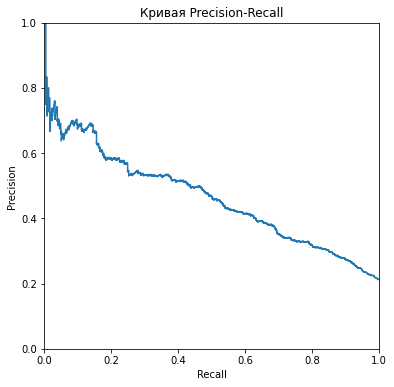

In [28]:
precision, recall, thresholds = precision_recall_curve(target_valid, probabilities_valid[:, 1])

plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.00])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall')
plt.show() 

AUC-ROC отличный результат на валидационной выборке!!

In [29]:
model = LogisticRegression(random_state=RANDOM_STATE, solver='liblinear')
model.fit(features_train_valid, target_train_valid)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

for threshold in np.arange(0, 0.3, 0.03):
    predicted_valid_test = probabilities_one_test > threshold# < напишите код здесь >
    precision = precision_score(target_test,predicted_valid_test)# < напишите код здесь >
    recall = recall_score(target_test,predicted_valid_test)# < напишите код здесь >
    print("Порог = {:.2f} | Точность = {:.3f}, Полнота = {:.3f}".format(
        threshold, precision, recall))
auc_roc_test = roc_auc_score(target_test,probabilities_one_test)
print('------------------------------------------------')
print(F'на тестовой выборке AUC-ROC: {auc_roc_test}')

Порог = 0.00 | Точность = 0.200, Полнота = 1.000
Порог = 0.03 | Точность = 0.200, Полнота = 1.000
Порог = 0.06 | Точность = 0.203, Полнота = 0.999
Порог = 0.09 | Точность = 0.211, Полнота = 0.970
Порог = 0.12 | Точность = 0.228, Полнота = 0.913
Порог = 0.15 | Точность = 0.252, Полнота = 0.838
Порог = 0.18 | Точность = 0.278, Полнота = 0.739
Порог = 0.21 | Точность = 0.304, Полнота = 0.641
Порог = 0.24 | Точность = 0.332, Полнота = 0.541
Порог = 0.27 | Точность = 0.357, Полнота = 0.434
------------------------------------------------
на тестовой выборке AUC-ROC: 0.6878595794030651


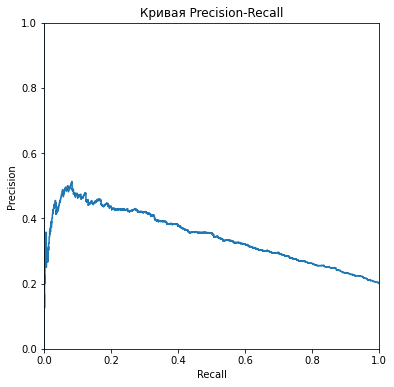

In [30]:
precision, recall, thresholds = precision_recall_curve(target_test, probabilities_test[:, 1])

plt.figure(figsize=(6, 6))
plt.step(recall, precision, where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.00])
plt.xlim([0.0, 1.0])
plt.title('Кривая Precision-Recall')
plt.show() 

AUC-ROC отличный результат на тестовой выборке!!

## Тестирование модели

### случайный лес

In [31]:
numeric_test = [ 'tenure','credit_score', 'balance', 'age','estimated_salary']
scaler = StandardScaler()
scaler.fit(features_train_valid[numeric_test])
features_train_valid[numeric_test]= scaler.transform(features_train_valid[numeric_test])
features_test[numeric_test] = scaler.transform(features_test[numeric_test])

In [32]:
features_upsampled_valid, target_upsampled_valid = upsample(features_train_valid, target_train_valid, 4)
features_downsampled, target_downsampled = downsample(features_train_valid, target_train_valid, 0.52)

Knn показала хуже результат чем рандом форест.

In [33]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
knn_pipe = Pipeline([('knn', KNeighborsClassifier(n_jobs=-1))])
knn_params = {'knn__n_neighbors': range(1, 10)}
knn_grid = GridSearchCV(knn_pipe, knn_params, cv=10, n_jobs=-1, verbose=1)

knn_grid.fit(features_downsampled, target_downsampled)
predicted_knn = knn_grid.predict(features_test) # получите предсказания модели
accuracy_knn = accuracy_score(target_test,predicted_knn) # посчитайте качество модели
print('f1 мера:',f1_score(target_test,predicted_knn))
print('accuracy на лучших показателях:',accuracy_knn)

Fitting 10 folds for each of 9 candidates, totalling 90 fits
f1 мера: 0.5352727272727273
accuracy на лучших показателях: 0.8243057464943635


In [34]:
grid_log = GridSearchCV(LogisticRegression(random_state=RANDOM_STATE),
                       param_grid={'C':[0.1,1,10.]},
                       cv=5,
                       verbose=4)
grid_log.fit(features_upsampled_valid, target_upsampled_valid)
predicted_log = grid_log.predict(features_test) # получите предсказания модели
accuracy_log = accuracy_score(target_test,predicted_log) # посчитайте качество модели
print('f1 мера:',f1_score(target_test,predicted_log))
print('accuracy на лучших показателях:',accuracy_log)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END ..........................................C=0.1; total time=   0.1s
[CV 2/5] END ..........................................C=0.1; total time=   0.2s
[CV 3/5] END ..........................................C=0.1; total time=   0.2s
[CV 4/5] END ..........................................C=0.1; total time=   0.2s
[CV 5/5] END ..........................................C=0.1; total time=   0.2s
[CV 1/5] END ............................................C=1; total time=   0.3s
[CV 2/5] END ............................................C=1; total time=   0.2s
[CV 3/5] END ............................................C=1; total time=   0.2s
[CV 4/5] END ............................................C=1; total time=   0.1s
[CV 5/5] END ............................................C=1; total time=   0.3s
[CV 1/5] END .........................................C=10.0; total time=   0.2s
[CV 2/5] END ....................................

In [35]:
rfc = RandomForestClassifier(class_weight='balanced',random_state=RANDOM_STATE)
search_space = {
    'n_estimators': [100,200,500,1000],
    'criterion': ['gini','entropy'],
    'max_features': ['auto','sqrt','log2']
}
GS_test = GridSearchCV(rfc,
                  search_space,
                  cv = 5,
                verbose = 1,
                  n_jobs=-1

)
#GS.fit(features_train_valid,target_train_valid)
GS_test.fit(features_upsampled_valid, target_upsampled_valid)
predicted_test = GS_test.predict(features_test) # получите предсказания модели
accuracy_test = accuracy_score(target_test,predicted_test) # посчитайте качество модели
print('f1 мера:',f1_score(target_test,predicted_test))
print('accuracy на лучших показателях:',accuracy_test)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
f1 мера: 0.6096654275092936
accuracy на лучших показателях: 0.8556502612042892


In [36]:
dummy = DummyClassifier(strategy='most_frequent', random_state=RANDOM_STATE).fit(features_train_valid, target_train_valid)
print('Accuracy Dummy-модели на тестовой выборке:', dummy.score(features_test,target_test))

Accuracy Dummy-модели на тестовой выборке: 0.7998350288699477


**Вывод:**

Нашу задачу мы выполнили F1 мера - 0.60 на тестовой выборке. Мы устранили дисбаланс классов и при помощи GridSearchCV нашли наилучший параметр для нашей регрессионной модели.

Так же мы проверили нашу модель на адекватностью . Тут результат тоже очень хороший получился Accuracy Dummy-модели на тестовой выборке: 0.79